<a href="https://colab.research.google.com/github/eengel7/transformer_speech_transcription/blob/main/training_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Pipeline

This notebook contains the training pipeline to fine and hyper-tune a pre-trained whisper model of huggingface.  The preproessed data is stored in Google Drive and consists of a training+ validation and a test data set. We will use the latter one to evaluate our training for every 1000 steps.





*   In this notebook, we will make use of a data collators which underlying task is to collect and organise informatio.  It will form a batch by using a list of dataset elements as input.  In our case, **DataCollatorSpeechSeq2SeqWithPadding** takes our pre-processed data and prepares PyTorch tensors ready for the model.  Note that the input_features must be handled by the feature extractor (padding) and the labels by the tokenizer (no padding).
*   After having organised the batches, we will now introduce the evaluation metric. We define a function **compute_metrics** that computes WER = word error rate that is based on the Levenshtein distance: 
WER = (S + D + I) / N = (S + D + I) / (S + D + C)
where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, N is the number of words in the reference (N=S+D+C).
The lower the value, the better the performance of the ASR system with a WER of 0 being a perfect score.

*   Since we use a pre-trained transformer model. we will then load a pre-trained checkpoint. One can choose between different model architectures and the baseline is of size small. 

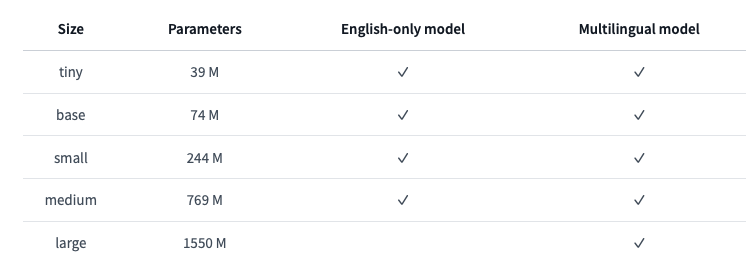

<font color='green'> In order to improve the fine-tuned small whisper model, we will consider using the medium version. Additonally, we need to configure the model to match our training set up. <font>

￼


*   Finally, we will define the training arguments  that the huggingface trainer will be used to construct the training schedule. 
<font color='green'>  Among a list of basic training parameters, we will add the option of saving checkpoints for continuing training in case the process crashes. In addition, we report to wanb to create dashboards that we can use to analyse our training. <font>


## Imports, GPU, logins

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  8 04:30:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!add-apt-repository -y ppa:jonathonf/ffmpeg-4
!apt update
!apt install -y ffmpeg
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install huggingface
!pip install huggingface_hub
!pip install transformers
!pip install wandb

from IPython.display import clear_output 
clear_output()


In [4]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [23]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
wandb.init(project="test-project", entity="two_data_scientists")

wandb: Currently logged in as: eengel7 (two_data_scientists). Use `wandb login --relogin` to force relogin


## Load pre-processed data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict.load_from_disk("drive/MyDrive/CommonVoice/common_voice_swedish_preprocessed.hf")

## Data collator

In [7]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [8]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


## Evaluation metric

In [9]:
import evaluate

metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

## Load pre-trained model

In [5]:
# Initialisation of small or medium whisper

openai_model = "openai/whisper-medium"

In [6]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(openai_model, language="Swedish", task="transcribe")

# load a pre-trained checkpoint
model = WhisperForConditionalGeneration.from_pretrained(openai_model)

processor = WhisperProcessor.from_pretrained(openai_model, language="Swedish", task="transcribe")

Downloading:   0%|          | 0.00/830 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/494k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [10]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

## Training arguments + training

In [32]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    num_train_epochs=1,
    output_dir="drive/MyDrive/CommonVoice/train_medium",  # change to a repo name of your choice
    per_device_train_batch_size=16, # 16 batch - 1 greadienr
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-4,
    warmup_steps=500,
    max_steps=6000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to= "wandb",
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    save_strategy = 'steps',
)

PyTorch: setting up devices


In [33]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)


/content/drive/MyDrive/CommonVoice/train_medium is already a clone of https://huggingface.co/eengel7/train_medium. Make sure you pull the latest changes with `repo.git_pull()`.
max_steps is given, it will override any value given in num_train_epochs
Using cuda_amp half precision backend


In [34]:
processor.save_pretrained(training_args.output_dir)


Feature extractor saved in drive/MyDrive/CommonVoice/train_medium/preprocessor_config.json
tokenizer config file saved in drive/MyDrive/CommonVoice/train_medium/tokenizer_config.json
Special tokens file saved in drive/MyDrive/CommonVoice/train_medium/special_tokens_map.json
added tokens file saved in drive/MyDrive/CommonVoice/train_medium/added_tokens.json


In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12360
  Num Epochs = 8
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6000
  Number of trainable parameters = 763857920
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
1000,0.203700,0.901911,46.099863
2000,0.128600,0.800861,40.517867


`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...
`use_cache = True` is incompatible with gradient c

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_11_0",
    "dataset": "Common Voice 11.0 - Swedish",  # a 'pretty' name for the training dataset
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Swedish_Survival_Kit",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
    "tags": "hf-asr-leaderboard",
}


In [ ]:
trainer.push_to_hub(**kwargs)


In [ ]:
from transformers import pipeline
import gradio as gr

pipe = pipeline(model="eengel7/train_first_try")  # change to "your-username/the-name-you-picked"

def transcribe(audio):
    text = pipe(audio)["text"]
    return text

iface = gr.Interface(
    fn=transcribe, 
    inputs=gr.Audio(source="microphone", type="filepath"), 
    outputs="text",
    title="Swedish Survival Kit",
    description="Realtime demo for Swedish speech recognition using a fine-tuned Whisper model.",
)

iface.launch()